In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "yourpath"
real_file_path = "yourpath/data_stream-oper_stepType-instant.nc"
ds = xr.open_dataset(real_file_path)


In [ ]:
print("\n[변수 목록]")
print(ds.data_vars)

print("\n[좌표 정보]")
print(ds.coords)


[변수 목록]
Data variables:
    d        (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    cc       (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    z        (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    o3       (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    pv       (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    r        (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    ciwc     (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    clwc     (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    q        (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    crwc     (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    cswc     (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    t        (valid_time, pressure_level, latitude, longitude) float32 83MB ...
    u        (v

## X_val, y_val 불러오기

In [ ]:
variables = ['d', 'cc', 'o3', 'pv', 'r', 'ciwc', 'clwc', 'q',
             'crwc', 'cswc', 't', 'u', 'v', 'w', 'vo', 'z']
level = 0
time_window = 16
target_variable = 'z'
selected_year = 2020

ds_year = ds.sel(valid_time=ds.valid_time.where(ds.valid_time.dt.year == selected_year, drop=True))

T_total = len(ds_year.valid_time)
H = len(ds_year.latitude)
W = len(ds_year.longitude)
C = len(variables)

print(f"Total time steps: {T_total}, Height: {H}, Width: {W}, Channels: {C}")

Total time steps: 368, Height: 201, Width: 281, Channels: 16


In [ ]:
sample_indices = list(range(time_window, T_total))
print(f"총 선택된 샘플 수: {len(sample_indices)}")

X_batch = []
y_batch = []
valid_time_batch = []

os.makedirs(file_path, exist_ok=True)

existing_files = sorted([f for f in os.listdir(file_path) if f.startswith('X_part')])
if existing_files:
    last_file = existing_files[-1]
    last_part_num = int(last_file.split('X_part')[-1].split('.npy')[0])
    X_batch = list(np.load(os.path.join(file_path, f'X_part{last_part_num}.npy')))
    y_batch = list(np.load(os.path.join(file_path, f'y_part{last_part_num}.npy')))
    valid_time_batch = list(np.load(os.path.join(file_path, f'valid_times_part{last_part_num}.npy')))
    start_idx = time_window + last_part_num * batch_size
    sample_indices = sample_indices[last_part_num * batch_size:] if last_part_num * batch_size < len(sample_indices) else []
    print(f"이어서 처리 시작: 인덱스 {start_idx}")
    part_num = last_part_num
else:
    part_num = 0


총 선택된 샘플 수: 352


In [ ]:
batch_size = 100

for idx in tqdm(sample_indices, desc="전체 시점 전처리"):
    feature = []
    for var in variables:
        data = ds_year[var].isel(pressure_level=level).values[idx-time_window:idx]
        feature.append(data)
    feature = np.stack(feature, axis=1)
    X_batch.append(feature)

    target = ds_year[target_variable].isel(pressure_level=level, valid_time=idx).values
    y_batch.append(target)

    valid_time_value = ds_year.valid_time[idx].values
    valid_time_batch.append(valid_time_value)

    if len(X_batch) == batch_size:
        part_num += 1
        np.save(os.path.join(file_path, f'X_part{part_num}.npy'), np.array(X_batch))
        np.save(os.path.join(file_path, f'y_part{part_num}.npy'), np.array(y_batch))
        np.save(os.path.join(file_path, f'valid_times_part{part_num}.npy'), np.array(valid_time_batch))
        print(f" 저장 완료: part{part_num} (데이터 개수: {len(X_batch)})")
        X_batch = []
        y_batch = []
        valid_time_batch = []

if X_batch:
    part_num += 1
    np.save(os.path.join(file_path, f'X_part{part_num}.npy'), np.array(X_batch))
    np.save(os.path.join(file_path, f'y_part{part_num}.npy'), np.array(y_batch))
    np.save(os.path.join(file_path, f'valid_times_part{part_num}.npy'), np.array(valid_time_batch))
    print(f"루프 후 잔여 저장 완료: part{part_num} (데이터 개수: {len(X_batch)})")

print("현재 저장된 파일 목록:")
for f in os.listdir(file_path):
    if f.endswith('.npy'):
        print(f)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch.utils.data import Dataset

class ERA5LazyDataset(Dataset):
    def __init__(self, x_files, y_files,
                 z_mean=5880, z_std=100,
                 uv_mean=0, uv_std=20,
                 t_mean=280, t_std=10):
        self.sample_index = []
        self.x_files = x_files
        self.y_files = y_files
        self.x_lens = []
        self.g = 9.80665

        self.z_mean, self.z_std = z_mean, z_std
        self.uv_mean, self.uv_std = uv_mean, uv_std
        self.t_mean, self.t_std = t_mean, t_std

        for file_idx, xf in enumerate(x_files):
            X = np.load(xf, mmap_mode='r')
            length = X.shape[0]
            self.x_lens.append(length)
            for i in range(length):
                self.sample_index.append((file_idx, i))

    def __len__(self):
        return len(self.sample_index)

    def __getitem__(self, idx):
        file_idx, sample_idx = self.sample_index[idx]

        x = np.load(self.x_files[file_idx], mmap_mode='r')[sample_idx]
        y = np.load(self.y_files[file_idx], mmap_mode='r')[sample_idx]

        x = x.copy()
        x[:, 0, :, :] = x[:, 0, :, :] / self.g

        y = y / self.g

        x[:, 0, :, :] = (x[:, 0, :, :] - self.z_mean) / self.z_std

        x[:, 1, :, :] = (x[:, 1, :, :] - self.uv_mean) / self.uv_std
        x[:, 2, :, :] = (x[:, 2, :, :] - self.uv_mean) / self.uv_std

        x[:, 3, :, :] = (x[:, 3, :, :] - self.t_mean) / self.t_std


        y = (y - self.z_mean) / self.z_std

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(0)

        return x, y


In [ ]:
x_files = sorted([os.path.join(file_path, f)
                  for f in os.listdir(file_path) if f.startswith('X_part')],
                 key=lambda s: int(s.split('X_part')[-1].split('.npy')[0]))
y_files = sorted([os.path.join(file_path, f)
                  for f in os.listdir(file_path) if f.startswith('y_part')],
                 key=lambda s: int(s.split('y_part')[-1].split('.npy')[0]))

if len(x_files) == 1:
    train_x, val_x = x_files, x_files
    train_y, val_y = y_files, y_files
else:
    split_idx = int(len(x_files) * 0.8)
    train_x, val_x = x_files[:split_idx], x_files[split_idx:]
    train_y, val_y = y_files[:split_idx], y_files[split_idx:]

train_dataset = ERA5LazyDataset(train_x, train_y)
val_dataset   = ERA5LazyDataset(val_x,   val_y)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False)

x_batch, y_batch = next(iter(train_loader))
print("x shape:", x_batch.shape)
print("y shape:", y_batch.shape)


x shape: torch.Size([4, 16, 16, 201, 281])
y shape: torch.Size([4, 1, 201, 281])


In [ ]:
X_train = np.random.rand(40, 10, 16, 201, 281).astype(np.float32)
y_train = np.random.rand(40, 201, 281).astype(np.float32)
X_val = np.random.rand(10, 10, 16, 201, 281).astype(np.float32)
y_val = np.random.rand(10, 201, 281).astype(np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).to(device)
y_train_tensor = torch.tensor(y_train).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val).to(device)
y_val_tensor = torch.tensor(y_val).unsqueeze(1).to(device)

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super().__init__()
        padding = kernel_size // 2
        self.hidden_channels = hidden_channels
        self.conv = nn.Conv2d(input_channels + hidden_channels,
                              4 * hidden_channels,
                              kernel_size,
                              padding=padding,
                              bias=bias)

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_out, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


In [ ]:
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels if isinstance(hidden_channels, list) else [hidden_channels]*num_layers
        self.cells = nn.ModuleList()
        for i in range(num_layers):
            in_channels = input_channels if i == 0 else self.hidden_channels[i-1]
            self.cells.append(ConvLSTMCell(in_channels, self.hidden_channels[i], kernel_size))

    def forward(self, x):
        N, T, C, H, W = x.size()
        h = [torch.zeros(N, self.hidden_channels[i], H, W, device=x.device) for i in range(self.num_layers)]
        c = [torch.zeros(N, self.hidden_channels[i], H, W, device=x.device) for i in range(self.num_layers)]

        outputs = []
        for t in range(T):
            input_t = x[:, t]
            for i, cell in enumerate(self.cells):
                h[i], c[i] = cell(input_t, h[i], c[i])
                input_t = h[i]
            outputs.append(h[-1])

        out = torch.stack(outputs, dim=1)
        return out, (h, c)


In [ ]:
class SimpleConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super().__init__()
        self.convlstm = ConvLSTM(input_channels, hidden_channels, kernel_size)
        self.conv_out = nn.Conv2d(hidden_channels, 1, kernel_size=1)

    def forward(self, x):
        out, _ = self.convlstm(x)
        last_out = out[:, -1, :, :, :]
        y_pred = self.conv_out(last_out)
        return y_pred


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(40, 10, 16, 201, 281)
(40, 201, 281)
(10, 10, 16, 201, 281)
(10, 201, 281)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

input_channels = len(variables)
hidden_channels = len(variables)
model = SimpleConvLSTM(input_channels=input_channels, hidden_channels=input_channels, kernel_size=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

Device: cuda


In [ ]:
print(X_train_tensor.shape)

torch.Size([40, 10, 16, 201, 281])


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime

num_epochs = 10
batch_size = 4

train_losses = []
val_losses = []

pred_list = []
actual_list = []
error_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

[Epoch 1/10] Training: 100%|██████████| 75/75 [00:59<00:00,  1.25it/s]


Epoch 1 - Train Loss: 1.3468, Val Loss: 1.6512


[Epoch 2/10] Training: 100%|██████████| 75/75 [00:48<00:00,  1.54it/s]


Epoch 2 - Train Loss: 1.3438, Val Loss: 1.6466


[Epoch 3/10] Training: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]


Epoch 3 - Train Loss: 1.3427, Val Loss: 1.6478


[Epoch 4/10] Training: 100%|██████████| 75/75 [00:49<00:00,  1.52it/s]


Epoch 4 - Train Loss: 1.3416, Val Loss: 1.6430


[Epoch 5/10] Training: 100%|██████████| 75/75 [00:49<00:00,  1.52it/s]


Epoch 5 - Train Loss: 1.3396, Val Loss: 1.6422


[Epoch 6/10] Training: 100%|██████████| 75/75 [00:48<00:00,  1.53it/s]


Epoch 6 - Train Loss: 1.3387, Val Loss: 1.6392


[Epoch 7/10] Training: 100%|██████████| 75/75 [00:49<00:00,  1.52it/s]


Epoch 7 - Train Loss: 1.3377, Val Loss: 1.6383


[Epoch 8/10] Training: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]


Epoch 8 - Train Loss: 1.3368, Val Loss: 1.6374


[Epoch 9/10] Training: 100%|██████████| 75/75 [00:48<00:00,  1.53it/s]


Epoch 9 - Train Loss: 1.3359, Val Loss: 1.6371


[Epoch 10/10] Training: 100%|██████████| 75/75 [00:49<00:00,  1.52it/s]


Epoch 10 - Train Loss: 1.3354, Val Loss: 1.6347


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

pred_list = []
actual_list = []
error_list = []

model.eval()

with torch.no_grad():
    for i in tqdm(range(len(val_loader.dataset))):

        x_sample = val_dataset[i][0].unsqueeze(0).to(device)
        y_true = val_dataset[i][1][0].cpu().numpy()

        y_pred_norm = model(x_sample).cpu().numpy()[0, 0]

        z_mean, z_std = 5880, 100


        pred_height = y_pred_norm * z_std + z_mean
        actual_height = y_true * z_std + z_mean
        abs_error = np.abs(pred_height - actual_height)

        pred_list.append(pred_height)
        actual_list.append(actual_height)
        error_list.append(abs_error)

100%|██████████| 52/52 [00:10<00:00,  4.80it/s]


In [ ]:
valid_time_files = sorted([f for f in os.listdir(file_path) if f.startswith('valid_times_part')])

val_time_raw = []
for file in valid_time_files:
    times = np.load(os.path.join(file_path, file))
    val_time_raw.extend(times)

print(f"총 valid_time 수: {len(val_time_raw)}")


총 valid_time 수: 352


In [ ]:
val_time_raw = []
for file in valid_time_files:
    times = np.load(os.path.join(file_path, file))
    val_time_raw.extend(times)

In [ ]:
z = ds['z'].sel(pressure_level=500)
time = ds['valid_time'].values
lat = ds['latitude'].values
lon = ds['longitude'].values

z = z / 9.80665

fig, ax = plt.subplots(figsize=(8, 6))
lon2d, lat2d = np.meshgrid(lon, lat)

val_time = [pd.to_datetime(str(t)) for t in val_time_raw]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
levels = np.linspace(5400, 6000, 21)
contour_level = [5880]

def update(frame):
    for ax in axes:
        ax.clear()

    pred = pred_list[frame]
    actual = actual_list[frame]
    err = error_list[frame]

    cf0 = axes[0].contourf(lon2d, lat2d, pred, levels=levels, cmap='viridis')
    cl0 = axes[0].contour(lon2d, lat2d, pred, levels=contour_level, colors='red')
    axes[0].clabel(cl0, fmt={5880: '5880'}, colors='red')
    axes[0].set_title("Predicted (500hPa)")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    cf1 = axes[1].contourf(lon2d, lat2d, actual, levels=levels, cmap='viridis')
    cl1 = axes[1].contour(lon2d, lat2d, actual, levels=contour_level, colors='blue')
    axes[1].clabel(cl1, fmt={5880: '5880'}, colors='blue')
    axes[1].set_title("Actual (500hPa)")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    cf2 = axes[2].contourf(lon2d, lat2d, err, levels=20, cmap='Reds')
    axes[2].set_title("Absolute Error")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")

    fig.suptitle(f"Date: {val_time[frame].strftime('%Y-%m-%d')}", fontsize=16)

ani = animation.FuncAnimation(fig, update, frames=len(pred_list), interval=300, blit=False)


In [ ]:
print(pred_list[0].shape)
print(actual_list[0].shape)
print(error_list[0].shape)

(201, 281)
(201, 281)
(201, 281)


In [ ]:
gif_save_path = "yourpath/예측_실제_오차_비교_지도스타일.gif"

ani.save(gif_save_path, writer='pillow', fps=3)

print("GIF 저장 완료:", gif_save_path)

GIF 저장 완료: /content/drive/MyDrive/[2025-1]_리빙랩/예측_실제_오차_비교_지도스타일.gif


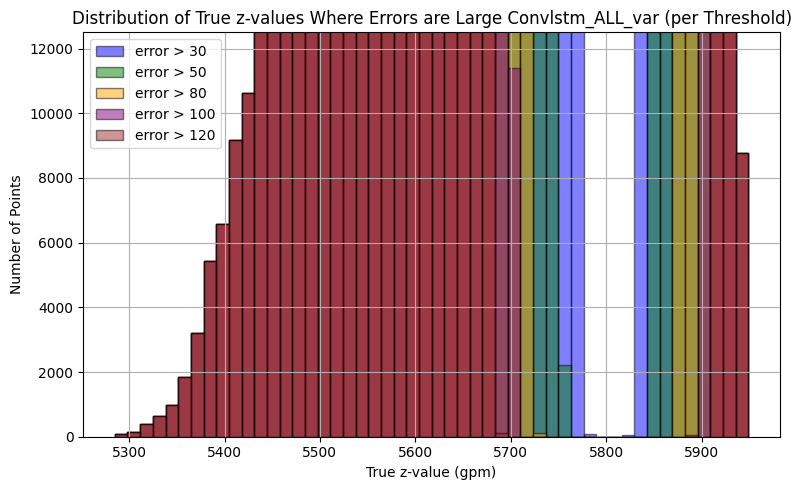

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Sans'
thresholds = [30,50,80,100,120]
z_distributions = {thr: [] for thr in thresholds}

for pred, actual in zip(pred_list, actual_list):
    error = np.abs(pred - actual)
    for thr in thresholds:
        mask = error > thr
        z_vals = actual[mask]
        z_distributions[thr].append(z_vals)

for thr in thresholds:
    z_distributions[thr] = np.concatenate(z_distributions[thr])

plt.figure(figsize=(8, 5))
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'red']

for thr, color in zip(thresholds, colors):
    plt.hist(z_distributions[thr], bins=50, alpha=0.5,
             label=f'error > {thr}', color=color, edgecolor='black')

plt.title("Distribution of True z-values Where Errors are Large Convlstm_ALL_var (per Threshold)")
plt.xlabel("True z-value (gpm)")
plt.ylabel("Number of Points")
plt.ylim(0,12500)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install shapely


In [ ]:
pred_contours = plt.contour(lon2d, lat2d, pred, levels=[5880])
actual_contours = plt.contour(lon2d, lat2d, actual, levels=[5880])

def create_mask_from_contours(contours, lon2d, lat2d):
    from matplotlib.path import Path

    mask = np.zeros_like(lon2d, dtype=bool)

    for seg in contours:
        path = Path(seg)
        points = np.vstack((lon2d.flatten(), lat2d.flatten())).T
        inside = path.contains_points(points).reshape(lon2d.shape)
        mask |= inside

    return mask

pred_mask = create_mask_from_contours(pred_contours.allsegs[0], lon2d, lat2d)
actual_mask = create_mask_from_contours(actual_contours.allsegs[0], lon2d, lat2d)

print("pred_mask sum:", pred_mask.sum())
print("actual_mask sum:", actual_mask.sum())

plt.imshow(pred_mask, origin='lower')
plt.title("Pred Mask")
plt.show()

plt.imshow(actual_mask, origin='lower')
plt.title("Actual Mask")
plt.show()



In [ ]:
def calculate_iou(pred, actual, lon2d, lat2d, contour_level=5880):
    from matplotlib.path import Path

    pred_contours = plt.contour(lon2d, lat2d, pred, levels=[contour_level])
    actual_contours = plt.contour(lon2d, lat2d, actual, levels=[contour_level])
    plt.close()

    def create_mask_from_contours(contours, lon2d, lat2d):
        mask = np.zeros_like(lon2d, dtype=bool)
        for seg in contours:
            path = Path(seg)
            points = np.vstack((lon2d.flatten(), lat2d.flatten())).T
            inside = path.contains_points(points).reshape(lon2d.shape)
            mask |= inside
        return mask

    if len(pred_contours.allsegs[0]) == 0 or len(actual_contours.allsegs[0]) == 0:
        return 0.0

    pred_mask = create_mask_from_contours(pred_contours.allsegs[0], lon2d, lat2d)
    actual_mask = create_mask_from_contours(actual_contours.allsegs[0], lon2d, lat2d)

    intersection = np.logical_and(pred_mask, actual_mask).sum()
    union = np.logical_or(pred_mask, actual_mask).sum()

    if union == 0:
        return 0.0

    return intersection / union


In [ ]:
iou_scores = []
val_time_plot = []

for frame in range(len(pred_list)):
    pred = pred_list[frame]
    actual = actual_list[frame]
    iou = calculate_iou(pred, actual, lon2d, lat2d, contour_level=5880)
    iou_scores.append(iou)
    val_time_plot.append(val_time[frame])


for t, iou in zip(val_time, iou_scores):
    print(f"{t.strftime('%Y-%m-%d')}: IOU = {iou:.4f}")


In [ ]:
import numpy as np

valid_ious = [iou for iou in iou_scores if not np.isnan(iou)]

if valid_ious:
    mean_iou = np.mean(valid_ious)
    print(f"평균 IOU (NaN 제외): {mean_iou:.4f}")
else:
    print("유효한 IOU 값이 없습니다.")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

valid_ious = [iou for iou in iou_scores if not np.isnan(iou)]

if valid_ious:
    mean_iou = np.mean(valid_ious)
    print(f"평균 IoU (NaN 제외): {mean_iou:.4f}")
else:
    print("유효한 IOU 값이 없습니다.")


plt.figure(figsize=(8, 4))
plt.hist(valid_ious, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of IoU Convlstm_ALL_var (except NaN)")
plt.xlabel("IOU")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 5))
plt.plot(val_time_plot, iou_scores, marker='o', linestyle='-', label='IOU')
plt.axhline(y=0.5, color='r', linestyle='--', label='IOU = 0.5 baseline')

plt.title('IOU over Validation Time Convlstm_ALL_var(z,t,u,v,q)')
plt.xlabel('Date')
plt.ylabel('IOU')
plt.ylim(0, 1.05)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


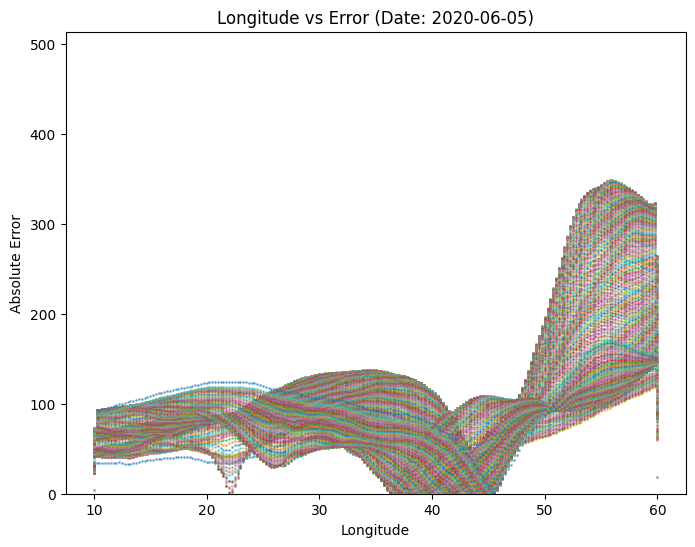

In [ ]:
all_errors = np.stack(error_list)
ymin = all_errors.min()
ymax = all_errors.max()

fig_error, ax_error = plt.subplots(figsize=(8, 6))

def update(frame):
    for ax in axes:
        ax.clear()

    pred = pred_list[frame]
    actual = actual_list[frame]
    err = error_list[frame]

    cf2 = axes[2].contourf(lon2d, lat2d, err, levels=20, cmap='Reds')
    axes[2].set_title("Absolute Error")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")

    ax_error.clear()
    ax_error.set_ylim(ymin, ymax)

    ax_error.set_title(f"Longitude vs Error (Date: {val_time[frame].strftime('%Y-%m-%d')})")
    ax_error.set_xlabel("Longitude")
    ax_error.set_ylabel("Absolute Error")

    for j in range(len(lon)):
         ax_error.plot(lat, err[:, j], '.', alpha=0.5, markersize=2)

    fig.suptitle(f"Date: {val_time[frame].strftime('%Y-%m-%d')}", fontsize=16)

ani_main = animation.FuncAnimation(fig, update, frames=len(pred_list), interval=300, blit=False)
ani_error = animation.FuncAnimation(fig_error, update, frames=len(pred_list), interval=300, blit=False)

In [ ]:
gif_save_path = "yourpath/Convlstm_ALL_var_산점도-경도.gif"
ani_error.save(gif_save_path, writer='pillow', fps=3)

print("GIF 저장 완료:", gif_save_path)

GIF 저장 완료: /content/drive/MyDrive/[2025-1]_리빙랩/Convlstm_ALL_var_산점도-경도.gif


## Feature importance 진행

In [ ]:
print(X_val.shape)
print(y_val.shape)

(10, 10, 16, 201, 281)
(10, 201, 281)


In [ ]:
var_names = ['d', 'cc', 'o3', 'pv', 'r', 'ciwc', 'clwc', 'q',
             'crwc', 'cswc', 't', 'u', 'v', 'w', 'vo', 'z']

from sklearn.metrics import mean_squared_error

def metric_fn(y_true, y_pred):
    return -mean_squared_error(y_true.flatten(), y_pred.flatten())


In [ ]:
import torch
import numpy as np
import copy

def compute_feature_importance(model, X_val, y_val, metric_fn, var_names):
    model.eval()

    with torch.no_grad():
        baseline_pred = model(X_val).squeeze(1).cpu().numpy()
    baseline_score = metric_fn(y_val, baseline_pred)

    print(f"[Baseline Score] {baseline_score:.4f}")

    importances = []

    for c in range(X_val.shape[2]):
        print(f"Shuffling variable: {var_names[c]}")
        X_shuffled = X_val.clone()

        for t in range(X_val.shape[1]):
            data = X_shuffled[:, t, c, :, :]
            idx = torch.randperm(data.size(0))
            X_shuffled[:, t, c, :, :] = data[idx]

        with torch.no_grad():
            pred = model(X_shuffled).squeeze(1).cpu().numpy()

        score = metric_fn(y_val, pred)
        importance = baseline_score - score
        importances.append(importance)
        print(f" → Importance: {importance:.4f}")

    return importances


In [ ]:
import matplotlib.pyplot as plt

def plot_importance(importances, var_names):
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(var_names)), np.array(importances)[sorted_idx])
    plt.xticks(range(len(var_names)), np.array(var_names)[sorted_idx], rotation=45)
    plt.title("Permutation Feature Importance (ConvLSTM)")
    plt.tight_layout()
    plt.show()


In [ ]:
print(type(X_val))
print(X_val.shape)


<class 'numpy.ndarray'>
(10, 10, 16, 201, 281)


In [ ]:
import torch

X_val = torch.from_numpy(X_val).float().to(device)


[Baseline Score] -1.1230
Shuffling variable: d
 → Importance: -0.0000
Shuffling variable: cc
 → Importance: -0.0000
Shuffling variable: o3
 → Importance: -0.0000
Shuffling variable: pv
 → Importance: -0.0000
Shuffling variable: r
 → Importance: 0.0000
Shuffling variable: ciwc
 → Importance: -0.0000
Shuffling variable: clwc
 → Importance: -0.0000
Shuffling variable: q
 → Importance: 0.0000
Shuffling variable: crwc
 → Importance: 0.0000
Shuffling variable: cswc
 → Importance: 0.0000
Shuffling variable: t
 → Importance: -0.0000
Shuffling variable: u
 → Importance: 0.0000
Shuffling variable: v
 → Importance: 0.0000
Shuffling variable: w
 → Importance: 0.0000
Shuffling variable: vo
 → Importance: 0.0000
Shuffling variable: z
 → Importance: 0.0000


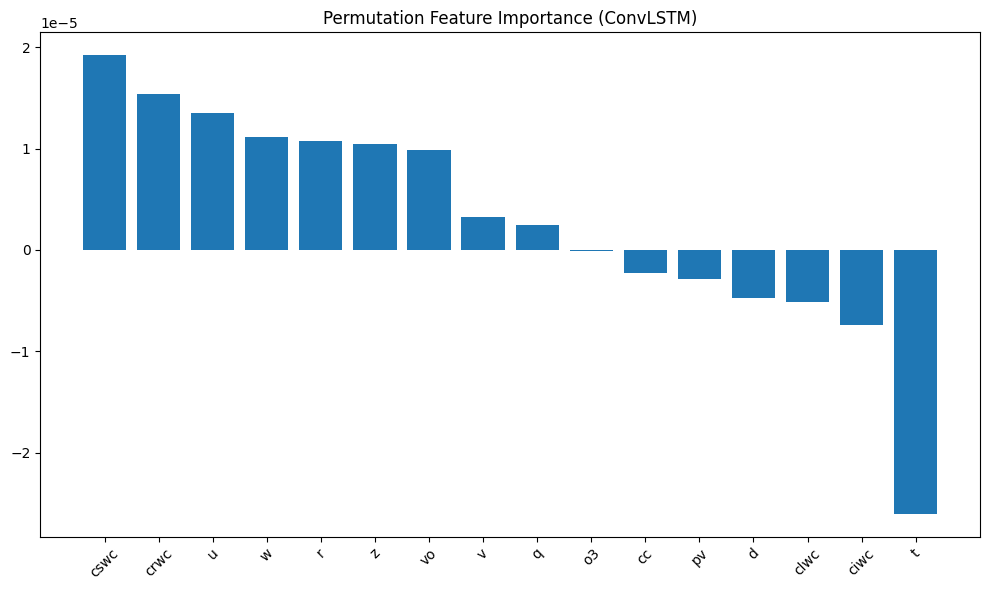

In [ ]:
var_names = ['d', 'cc', 'o3', 'pv', 'r', 'ciwc', 'clwc', 'q',
             'crwc', 'cswc', 't', 'u', 'v', 'w', 'vo', 'z']

importances = compute_feature_importance(model, X_val, y_val, metric_fn, var_names)
plot_importance(importances, var_names)

